In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model

In [2]:
!nvidia-smi

Fri May  7 15:49:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   49C    P8    14W / 150W |      0MiB /  7618MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
base_dir = './findog2'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
        rescale=1/255,    
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
#     color_mode='grayscale',
    target_size=(200,200),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode='grayscale',
    target_size=(200,200),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
#     color_mode='grayscale',
    target_size=(200,200),
    batch_size=100,
    class_mode='categorical'
)

Found 15364 images belonging to 87 classes.
Found 3797 images belonging to 87 classes.
Found 0 images belonging to 87 classes.


# 전이 학습

In [4]:
# pretrained network
model_base = EfficientNetB0(include_top=False, 
                            weights='imagenet', input_shape=(200,200,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 200, 200, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 200, 200, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 201, 201, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [5]:
model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(87, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 87)                5456727   
Total params: 9,506,298
Trainable params: 5,456,727
Non-trainable params: 4,049,571
_________________________________________________________________


# Fine Tuning

In [6]:
'''
model_base.trainable=True

# 상위 layer 동결해제
for layer in model_base.layers:
    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:
        layer.trainable=True
    else:
        layer.trainable=False

# learning_rate 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])
'''

"\nmodel_base.trainable=True\n\n# 상위 layer 동결해제\nfor layer in model_base.layers:\n    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:\n        layer.trainable=True\n    else:\n        layer.trainable=False\n\n# learning_rate 더 작게 설정\nmodel.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',\n              metrics=['accuracy'])\n"

In [7]:
'''
plot_model(model, show_shapes=True, rankdir='TB', dpi=96, 
           to_file='./models/융합프로젝트.png')'''

"\nplot_model(model, show_shapes=True, rankdir='TB', dpi=96, \n           to_file='./models/융합프로젝트.png')"

In [8]:
history = model.fit(train_generator, steps_per_epoch=150, epochs=30,
                    validation_data=validation_generator, validation_steps=37)

Epoch 1/30
150/150 [==============================] - 59s 343ms/step - loss: 4.9457 - accuracy: 0.0117 - val_loss: 4.6770 - val_accuracy: 0.0141
Epoch 2/30
150/150 [==============================] - 49s 327ms/step - loss: 4.8599 - accuracy: 0.0144 - val_loss: 4.6522 - val_accuracy: 0.0149
Epoch 3/30
150/150 [==============================] - 49s 326ms/step - loss: 4.8703 - accuracy: 0.0116 - val_loss: 4.6408 - val_accuracy: 0.0146
Epoch 4/30
150/150 [==============================] - 49s 328ms/step - loss: 4.8497 - accuracy: 0.0110 - val_loss: 4.7614 - val_accuracy: 0.0119
Epoch 5/30
150/150 [==============================] - 50s 330ms/step - loss: 4.8625 - accuracy: 0.0128 - val_loss: 4.6290 - val_accuracy: 0.0168
Epoch 6/30
150/150 [==============================] - 49s 328ms/step - loss: 4.8422 - accuracy: 0.0121 - val_loss: 4.6975 - val_accuracy: 0.0141
Epoch 7/30
150/150 [==============================] - 49s 326ms/step - loss: 4.8401 - accuracy: 0.0152 - val_loss: 4.6723 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


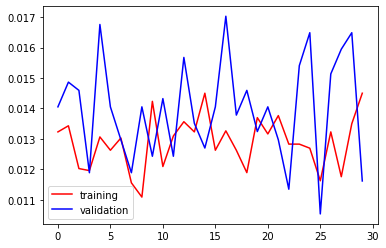

In [9]:
# history 객체 확인
print(history.history.keys())

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training')
plt.plot(validation_acc, color='b', label='validation')
plt.legend()
#plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_acc.jpg')
plt.show()

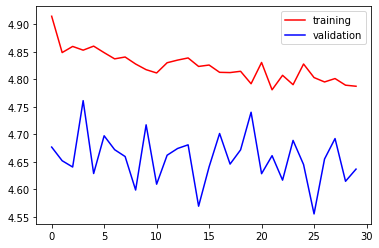

In [10]:
plt.plot(train_loss, color='r', label='training')
plt.plot(validation_loss, color='b', label='validation')
plt.legend()
#plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_val.jpg')
plt.show()

In [11]:
result = model.evaluate(validation_generator)
print(np.round(result, 4))

38/38 [==============================] - 11s 276ms/step - loss: 4.6368 - accuracy: 0.0116
[4.6368 0.0116]


In [12]:
#model.save('./models/InceptionResNetV2_1/InceptionResNetV2_1-1.h5')